<a href="https://colab.research.google.com/github/Ragul-SL/Non-Invasive-BloodPressure/blob/main/Estimate_BP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credits to BRUNO G. DO AMARAL**
https://www.kaggle.com/code/bguberfain/reading-and-showing-data

In [3]:
import numpy as np
import pandas as pd
import json
from os.path import join
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

In [7]:
input_path = '/content/Cuff-less Non-invasive Blood Pressure Estimation Data Set'
num_patients = 26

In [8]:
with open(join(input_path, '1.json'), 'r') as f:
    data = json.load(f)

In [9]:
data_keys = ['data_PPG', 'data_ECG', 'data_PCG', 'data_FSR', 'data_BP']

In [10]:
{k: len(data[k]) for k in data_keys}

{'data_PPG': 280000,
 'data_ECG': 280000,
 'data_PCG': 280000,
 'data_FSR': 280000,
 'data_BP': 4}

In [11]:
data['data_BP']

[{'SBP': 141, 'DBP': 82},
 {'SBP': 134, 'DBP': 73},
 {'SBP': 125, 'DBP': 70},
 {'SBP': 118, 'DBP': 57}]

# FSR series

This series is important to align with BP measurement. There are 280000 samples for this series, while only 4 measurements of BP.

As stated here, the BP measurement is done when FSR goes down. The next cells are dedicated to find these points.

We first invert the FSR as stated here.

First we plot the raw series.

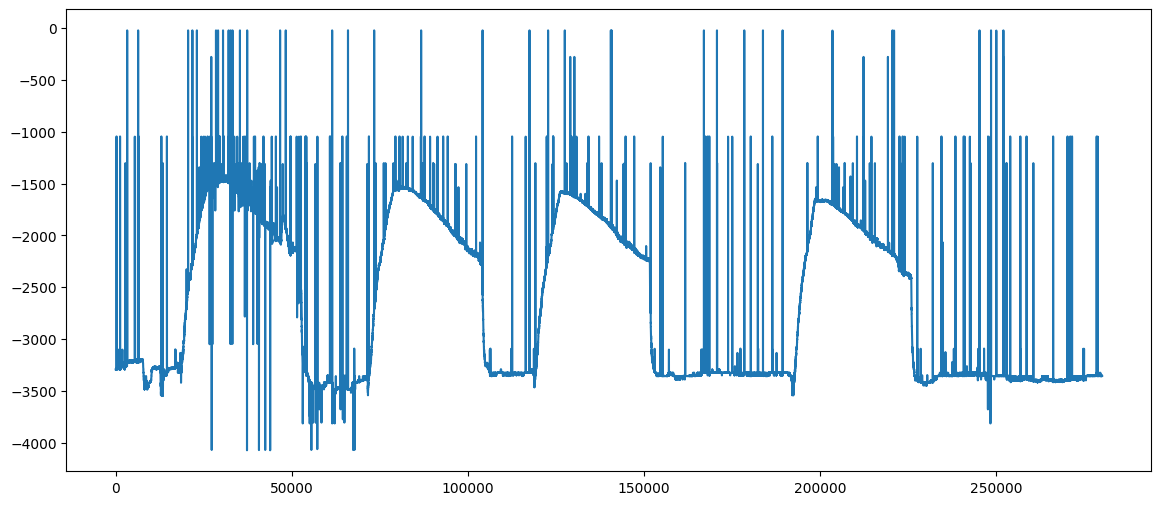

In [12]:
plt.figure(figsize=(14, 6))
data_FSR = -np.array(data['data_FSR'])
plt.plot(data_FSR);

We can notice that there are a lot of outliers values that polutes the series. Let's get take than off by analysing the difference between two consecutive samples and exclude those above a threshold (here we set to 50).

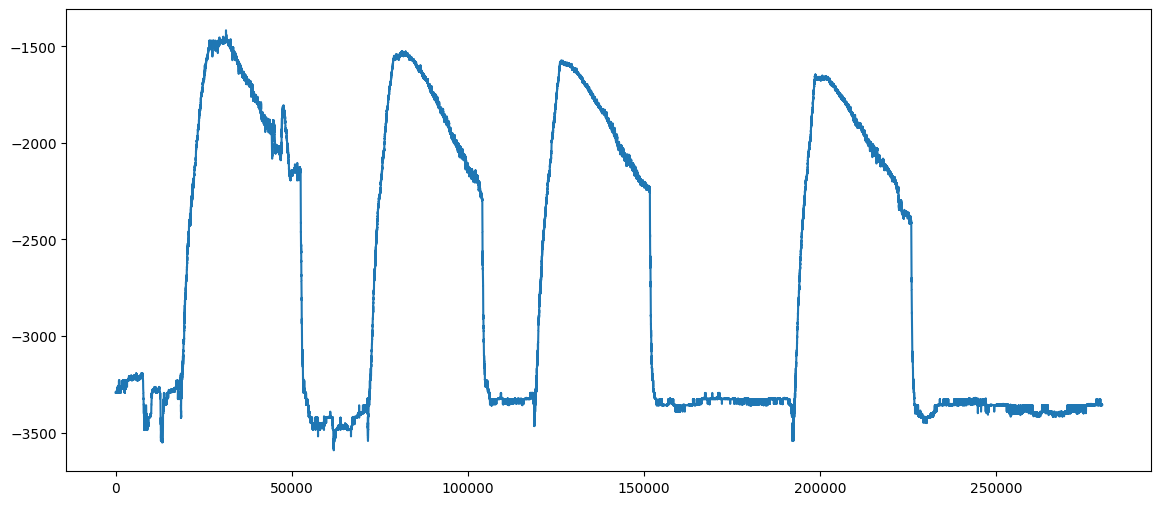

In [14]:
# Set to nan elements whose slope is above 50
plt.figure(figsize=(14, 6))
max_diff = 50
data_FSR_clear = np.array(data_FSR, dtype=np.float64)
data_FSR_outliers = np.abs(data_FSR[1:] - data_FSR[:-1]) > max_diff
data_FSR_outliers = np.append(data_FSR_outliers, False)
data_FSR_clear[data_FSR_outliers] = np.nan
plt.plot(data_FSR_clear);

This is a more clear series, but contains NaN (hidden on the chart). Let's replace then by a local moving average.


In [17]:
# http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [18]:
# Replace nan with local mean
mean_window = 10

data_FSR_roll_mean = np.nanmean(rolling_window(data_FSR_clear, mean_window), axis=-1)

data_FSR_clear[np.isnan(data_FSR_clear)] = \
    data_FSR_roll_mean[np.isnan(data_FSR_clear)[:1-mean_window]]

assert np.isnan(data_FSR_clear).sum() == 0

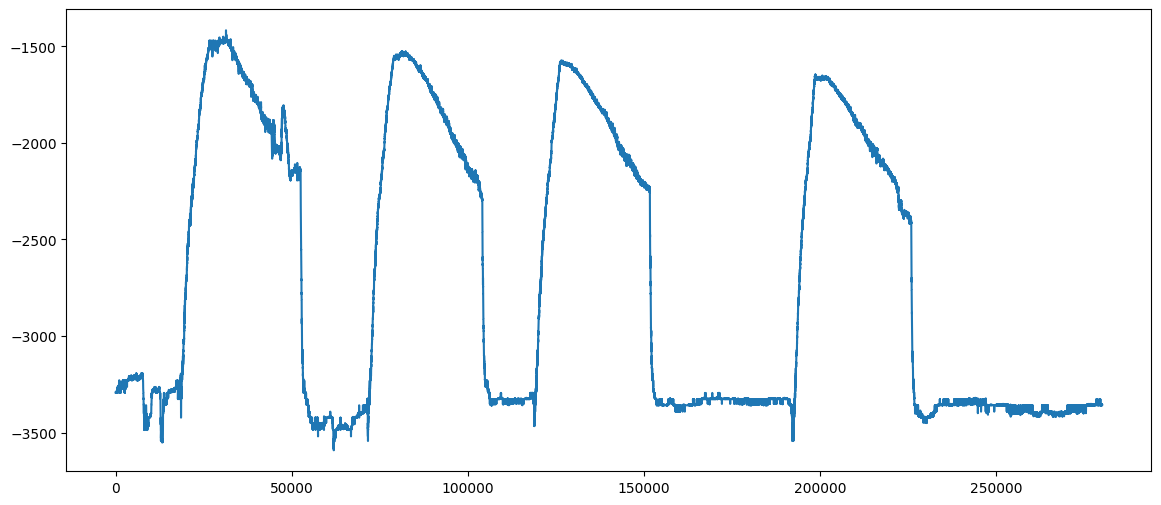

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(data_FSR_clear);


Now we can still apply a small smooth to clean high-frequency noise.

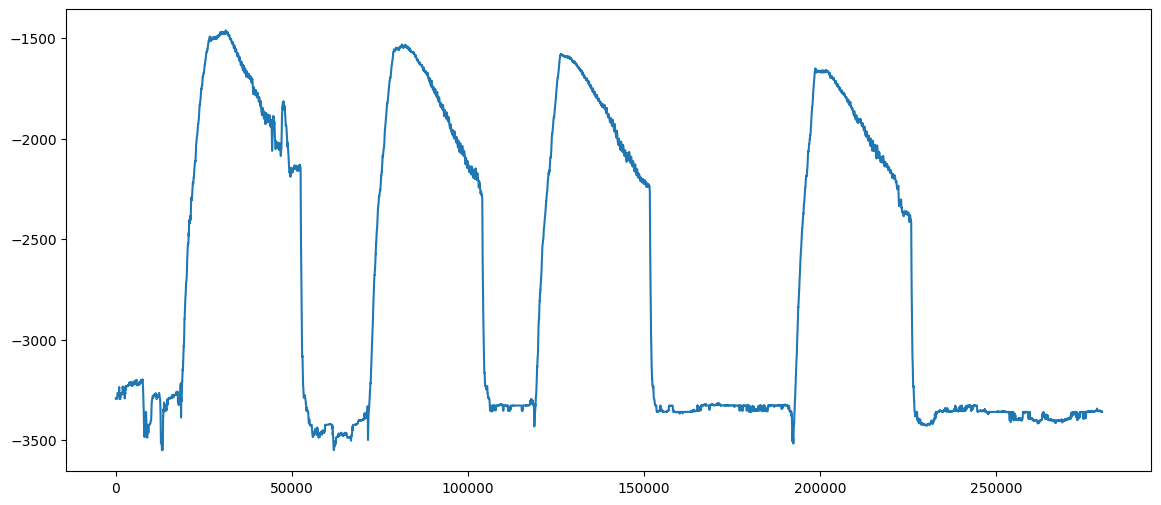

In [20]:
# Smooth version of signal FSR
plt.figure(figsize=(14, 6))
data_FSR_smooth = signal.savgol_filter(data_FSR_clear, 51, 0)
plt.plot(data_FSR_smooth);


# Finding transitions
Here we will use slope of the series to find the minimas, that indicates the BP measurement points.

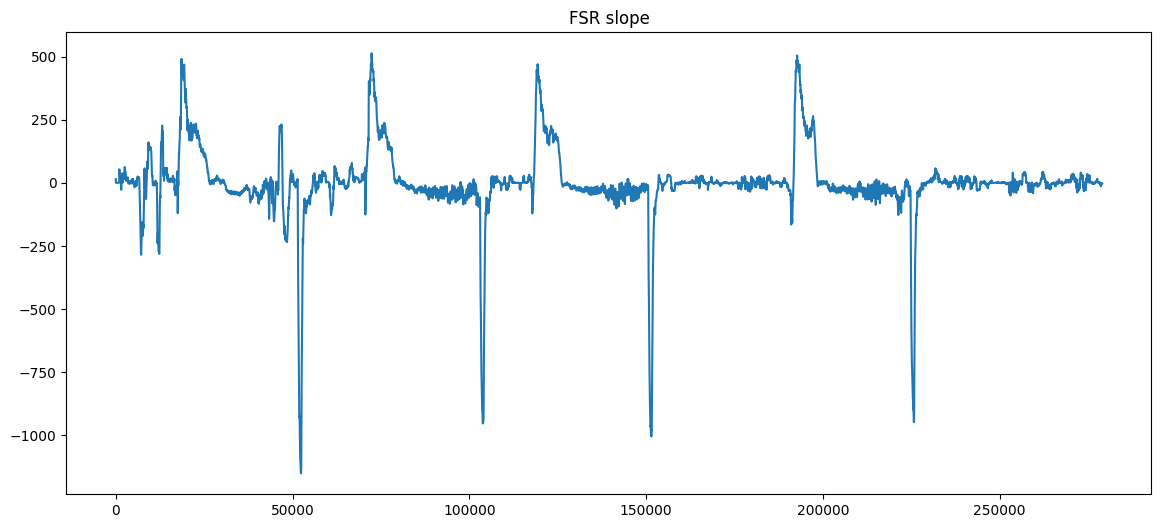

In [21]:
plt.figure(figsize=(14, 6))
diff_n = 1000
roll_window = 21
data_FSR_diff = data_FSR_smooth[diff_n:] - data_FSR_smooth[:-diff_n]
data_FSR_diff_roll = rolling_window(data_FSR_diff, roll_window).mean(axis=-1)
plt.title('FSR slope')
plt.plot(data_FSR_diff_roll);

This is a simple algorithm to find the num_mins within window.

At each iteration, one for each num_mins, it first finds the minumin value of the series than set a window around this minimum to maximum value. The next iteration will find a new minima outside this window.

It returns precisely num_mins values (one for each BP measurement).

In [22]:
num_mins = len(data['data_BP'])
min_window = 15000

def find_mins(a, num_mins, window):
    found_mins = []
    amax = a.max()

    hwindow = window // 2

    a = np.array(a)

    for i in range(num_mins):
        found_min = np.argmin(a)
        found_mins.append(found_min)
        a[found_min-hwindow:found_min+hwindow] = amax

    del a

    return sorted(found_mins)

data_FSR_mins = find_mins(data_FSR_diff_roll, num_mins, min_window)

Here is the final result. Vertical red lines marks the BP measurements.



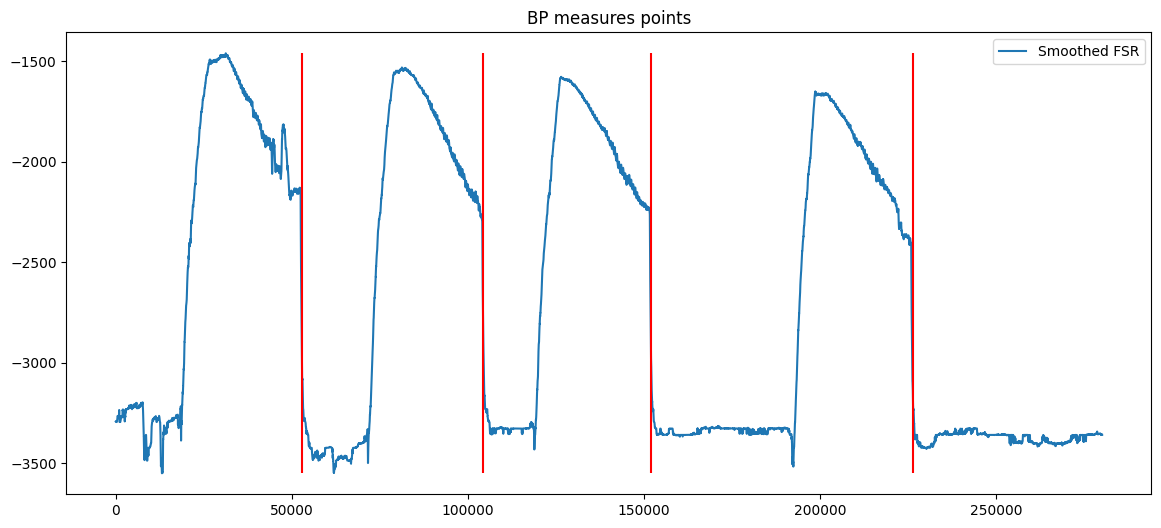

In [23]:
plt.figure(figsize=(14, 6))
plt.plot(data_FSR_smooth, label='Smoothed FSR')

data_FSR_max, data_FSR_min = data_FSR_smooth.max(), data_FSR_smooth.min()
for m in data_FSR_mins:
    plt.vlines(m + diff_n/2, data_FSR_min, data_FSR_max, color='red')
plt.legend()
plt.title('BP measures points');